## Import Data ##

In [824]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.transforms import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import random
from scipy.stats import *
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [204]:
image_path = []
labels = []

for i in os.listdir("/Users/jay/Jupyter Projects/Fire/fire_dataset"):
    for label in os.listdir(f"/Users/jay/Jupyter Projects/Fire/fire_dataset/{i}"):
        for image in os.listdir(f"/Users/jay/Jupyter Projects/Fire/fire_dataset/{i}"):
            image_path.append(f"/Users/jay/Jupyter Projects/Fire/fire_dataset/{i}/{image}")
            labels.append(i)

df = pd.DataFrame(zip(image_path, labels), columns = ["image_path", "labels"])
df = df.drop_duplicates().reset_index(drop=True)
df

image_path           labels
0    /Users/jay/Jupyter Projects/Fire/fire_dataset/...  non_fire_images
1    /Users/jay/Jupyter Projects/Fire/fire_dataset/...  non_fire_images
2    /Users/jay/Jupyter Projects/Fire/fire_dataset/...  non_fire_images
3    /Users/jay/Jupyter Projects/Fire/fire_dataset/...  non_fire_images
4    /Users/jay/Jupyter Projects/Fire/fire_dataset/...  non_fire_images
..                                                 ...              ...
994  /Users/jay/Jupyter Projects/Fire/fire_dataset/...      fire_images
995  /Users/jay/Jupyter Projects/Fire/fire_dataset/...      fire_images
996  /Users/jay/Jupyter Projects/Fire/fire_dataset/...      fire_images
997  /Users/jay/Jupyter Projects/Fire/fire_dataset/...      fire_images
998  /Users/jay/Jupyter Projects/Fire/fire_dataset/...      fire_images

[999 rows x 2 columns]

In [18]:
place = []

i = 0
for i in range(len(df)):
    ima = np.array(Image.open(df.iloc[i,0]).convert("RGB").resize([128, 128])).ravel()
    lab = df["labels"].head(i+1)
    place.append(ima)
    i += 1

place_df = pd.concat([pd.DataFrame(place), pd.DataFrame(lab)], axis=1)

place_df

0    1    2    3    4    5    6    7    8    9  ...  49143  49144  \
0     74   86   74   67   81   66   48   62   48   33  ...     94    113   
1     15   15   13   14   15   12   19   19   14   35  ...     60     37   
2    232  231  229  231  230  228  232  231  229  232  ...     96     91   
3     75   77    3   86   92    1  123  137   43  116  ...    233    225   
4     58   41   56   59   42   57   58   43   56   59  ...     58     31   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
994  236  220  223  237  221  224  239  223  225  236  ...    136    129   
995   61   47   12   77   59   16   87   66   19   74  ...    191    140   
996   49    7    2   48    7    2   57    8    1   67  ...     81     14   
997  116  136  156  113  134  154  110  133  154  109  ...    154    174   
998  142  128  101  164  149  119  156  140  109  147  ...    161    129   

     49145  49146  49147  49148  49149  49150  49151           labels  
0       99     78     95     84     58     72     64  non_fire_images  
1       19     60     39     16     53     31      9  non_fire_images  
2       41    131     99     45    132    122     51  non_fire_images  
3      121    245    238    131    246    242    154  non_fire_images  
4       50     58     31     50     58     31     50  non_fire_images  
..     ...    ...    ...    ...    ...    ...    ...              ...  
994    149    170    152    165    192    166    172      fire_images  
995     52    189    139     53    194    142     50      fire_images  
996      4     76     11      2     75     10      2      fire_images  
997    196    154    173    193    152    171    189      fire_images  
998     86    131     97     62    120     87     52      fire_images  

[999 rows x 49153 columns]

In [206]:
def drop():
    global X
    global y
    
    X = place_df.drop(columns=["labels"])
    y = place_df["labels"]

drop()

## Statistical Modeling ##

Shape:  (999, 2)

Counts:
 labels
fire_images        755
non_fire_images    244
Name: count, dtype: int64



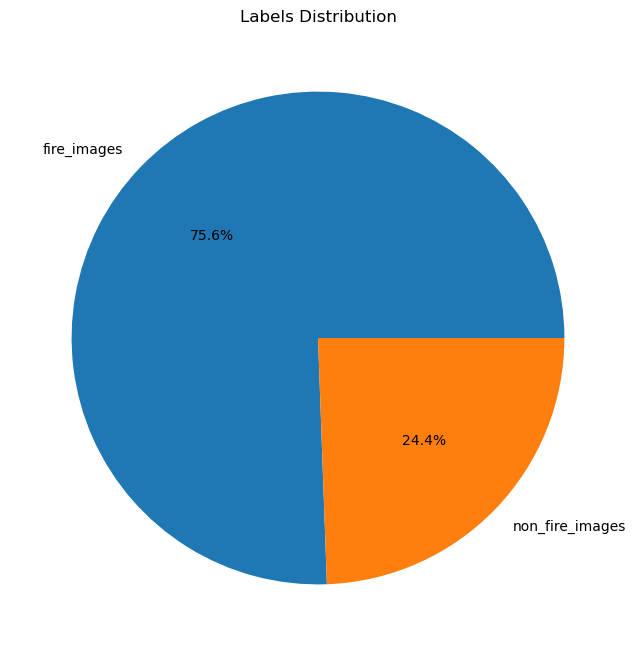

In [151]:
print("Shape: ", df.shape)
print("\nCounts:\n", df["labels"].value_counts())

print()

plt.figure(figsize=(8,8))
plt.pie(df["labels"].value_counts(), labels = df["labels"].value_counts().index, autopct="%1.1f%%")
plt.title("Labels Distribution")
plt.show()

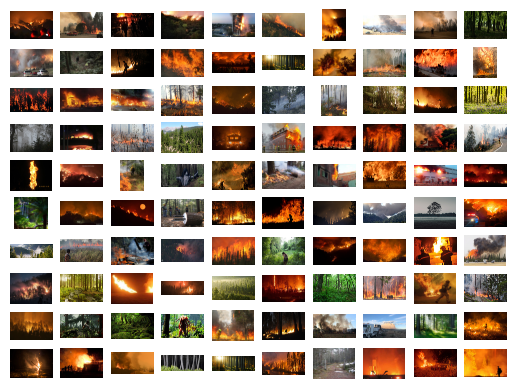

In [24]:
#100 random images
n_rows = 10
n_cols = 10

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(df.sample(n=1)["image_path"].iloc[0]).convert("RGB")
        axarr[row, col].imshow(image)
        axarr[row, col].axis("off")

plt.show()

Number of clusters in image 1: 39
Number of clusters in image 2: 37
Number of clusters in image 3: 11
Number of clusters in image 4: 138
Number of clusters in image 5: 30


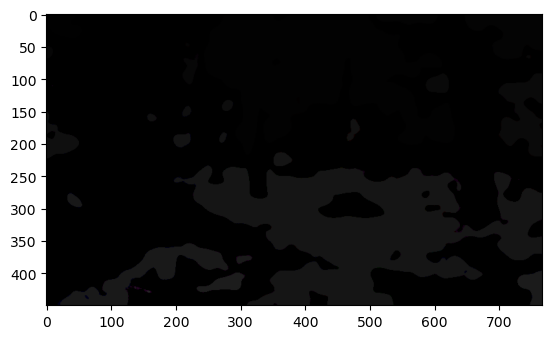

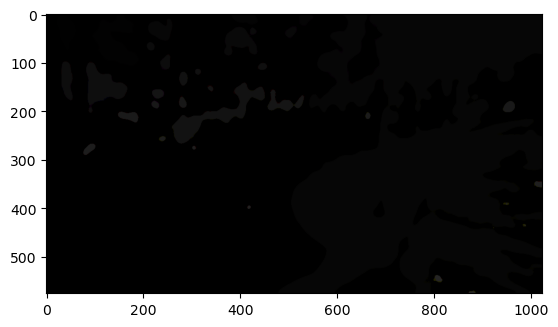

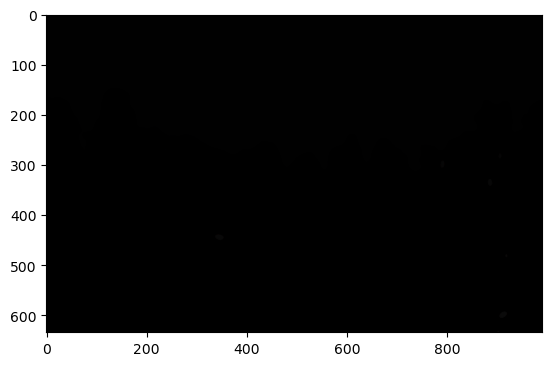

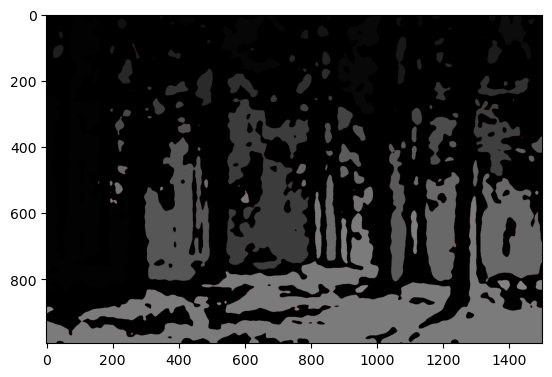

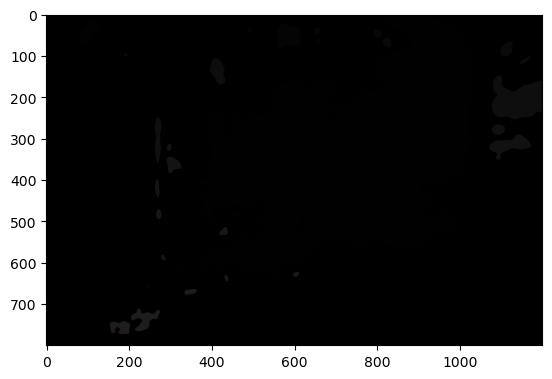

In [183]:
from scipy import ndimage

for i in range(5):
    plt.figure()
    
    im = Image.open(df.iloc[i, 0])
    im2 = ndimage.gaussian_filter(im, sigma=256/(8.*5))
    plt.imshow(im2);
    mask = im2 > im2.mean()
    label_im, nb_labels = ndimage.label(mask)
    print(f"Number of clusters in image {i+1}: {nb_labels}")
    plt.imshow(label_im);
    i += 1

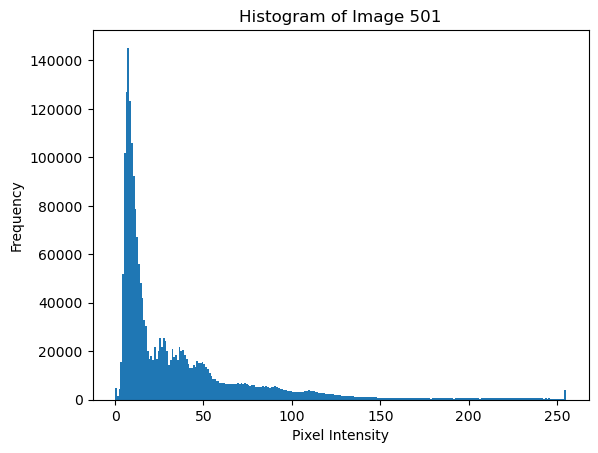

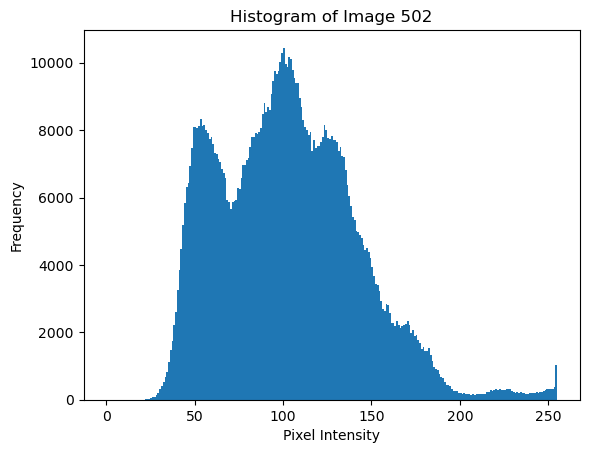

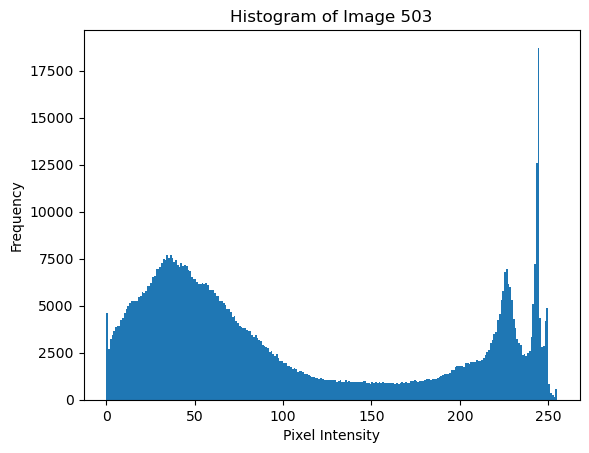

In [142]:
for i in range(3):
    plt.figure()
    
    img_data = np.array(Image.open(df.iloc[i+500, 0])).ravel()
    
    plt.hist(img_data, bins=range(256))
    
    plt.title(f"Histogram of Image {i+501}")
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')

    plt.show()

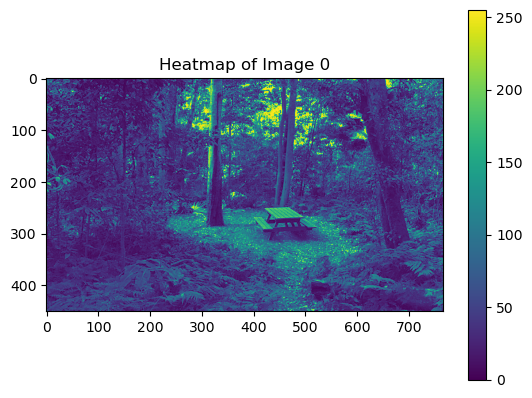

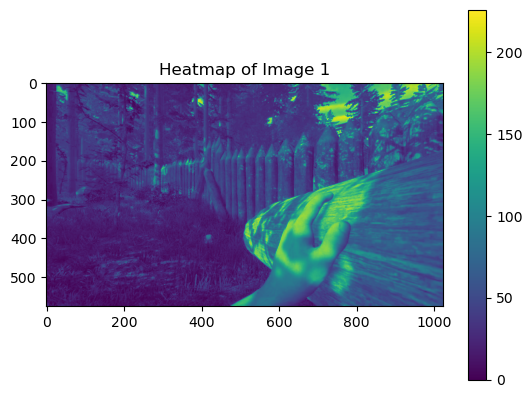

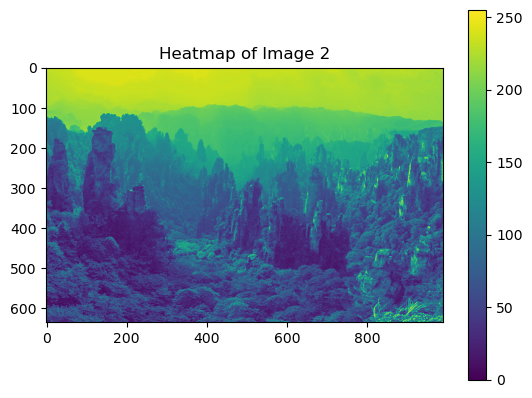

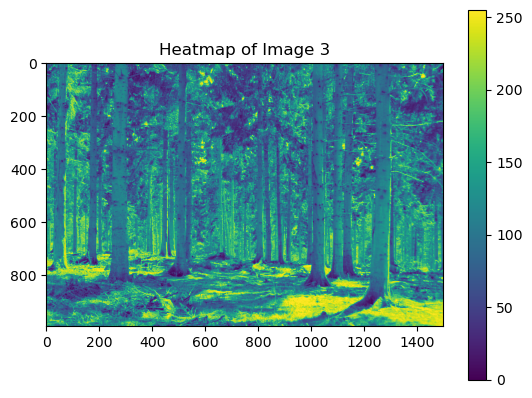

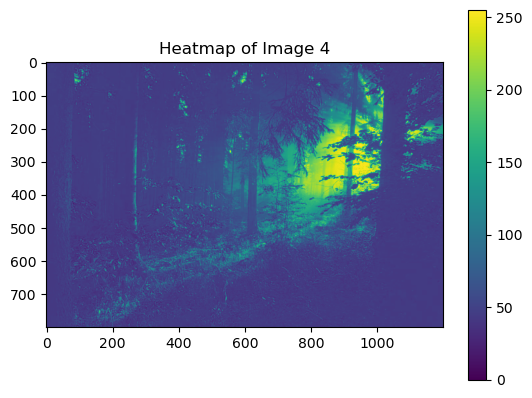

In [139]:
for i in range(5):
    plt.figure()

    img_data = np.array(Image.open(df.iloc[i, 0]))

    cax = plt.imshow(img_data, cmap='viridis', interpolation='nearest')

    plt.title(f"Heatmap of Image {i}")

    plt.colorbar(cax)

    plt.imshow(img_data[:, :, 0])

## Training Model ##

In [210]:
train = df.sample(frac = 0.7)
test = df.drop(train.index)

val = test.sample(frac = 0.5)
test = test.drop(val.index)

print(train.shape)
print(test.shape)
print(val.shape)

(699, 2)
(150, 2)
(150, 2)


In [872]:
class NumpyOperations:
    def __init__(self, rotation_probability=0.5):
        self.rotation_probability = rotation_probability

    def __call__(self, image):
        image_np = np.array(image)
        
        image_np = image_np / 255.0
        
        if random.random() < 0.5:
            image_np = np.rot90(image_np)
        
        image_np = image_np.copy()
        
        image_pil = Image.fromarray((image_np * 255).astype(np.uint8))
        
        return image_pil

In [874]:
le = LabelEncoder()
le.fit(df["labels"])

transform = transforms.Compose([
    transforms.Resize([128, 128]),
    NumpyOperations(),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

In [876]:
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, transform = None, rotation_probability=0.5):
        self.dataframe = dataframe
        self.transform = transform
        self.rotation_probability = rotation_probability
        self.rotate_transform = NumpyOperations(rotation_probability)
        self.labels = torch.tensor(le.transform(dataframe["labels"])).to(device)

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image).to(device)

        return image, label

In [878]:
train_dataset = CustomImageDataset(dataframe = train, transform = transform)
val_dataset = CustomImageDataset(dataframe = val, transform = transform)
test_dataset = CustomImageDataset(dataframe = test, transform = transform)

In [880]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

In [882]:
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [884]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)

        self.pooling = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128*16*16), 128)

        self.output = nn.Linear(128, len(df["labels"].unique()))

    def forward(self, x):
        x = self.conv1(x) #(32, 128, 128)
        x = self.pooling(x) #(32, 64, 64)
        x = self.relu(x)

        x = self.conv2(x) #(64, 64, 64)
        x = self.pooling(x) #(64, 32, 32)
        x = self.relu(x)

        x = self.conv3(x) #(128, 32, 32)
        x = self.pooling(x) #(128, 16, 16) same as number in self.linear
        x = self.relu(x)

        x = self.flatten(x)
        x = self.linear(x)
        x = self.output(x)
        return x

In [886]:
model = Net().to(device)

In [888]:
summary(model)

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            896
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─MaxPool2d: 1-4                         --
├─ReLU: 1-5                              --
├─Flatten: 1-6                           --
├─Linear: 1-7                            4,194,432
├─Linear: 1-8                            258
Total params: 4,287,938
Trainable params: 4,287,938
Non-trainable params: 0

In [890]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr = LR)

In [892]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()
            
            val_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
            total_acc_val += val_acc
        
    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    
    total_acc_train_plot.append(round(total_acc_train/train_dataset.__len__()*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/val_dataset.__len__()*100, 4))

    print(f'''Epoch no. {epoch+1}/{EPOCHS} 
    Training Loss: {round(total_loss_train/1000, 4)} 
    Training Accuracy: {round(total_acc_train/train_dataset.__len__()*100, 4)} 
    Validation Loss: {round(total_loss_val/1000, 4)} 
    Validation Accuracy: {round(total_acc_val/val_dataset.__len__()*100, 4)}''')

    print("="*50)

Epoch no. 1/10 
    Training Loss: 0.0194 
    Training Accuracy: 80.1144 
    Validation Loss: 0.0024 
    Validation Accuracy: 92.6667
Epoch no. 2/10 
    Training Loss: 0.0106 
    Training Accuracy: 89.9857 
    Validation Loss: 0.0014 
    Validation Accuracy: 97.3333
Epoch no. 3/10 
    Training Loss: 0.0071 
    Training Accuracy: 94.4206 
    Validation Loss: 0.001 
    Validation Accuracy: 96.6667
Epoch no. 4/10 
    Training Loss: 0.0066 
    Training Accuracy: 94.4206 
    Validation Loss: 0.0009 
    Validation Accuracy: 97.3333
Epoch no. 5/10 
    Training Loss: 0.0059 
    Training Accuracy: 95.422 
    Validation Loss: 0.0011 
    Validation Accuracy: 95.3333
Epoch no. 6/10 
    Training Loss: 0.0052 
    Training Accuracy: 94.5637 
    Validation Loss: 0.001 
    Validation Accuracy: 96.0
Epoch no. 7/10 
    Training Loss: 0.0053 
    Training Accuracy: 95.7082 
    Validation Loss: 0.0008 
    Validation Accuracy: 97.3333
Epoch no. 8/10 
    Training Loss: 0.0053 
    

In [894]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        predictions = model(inputs)
        
        acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
        total_acc_test += acc
        
        test_loss = criterion(predictions, labels)
        total_loss_test += test_loss.item()

print(f'''Accuracy Score: {round((total_acc_test/test_dataset.__len__())*100, 4)} 
Loss: {round(total_loss_test/1000, 4)}''')

Accuracy Score: 98.6667 
Loss: 0.0005


## Post-Training Analysis ##

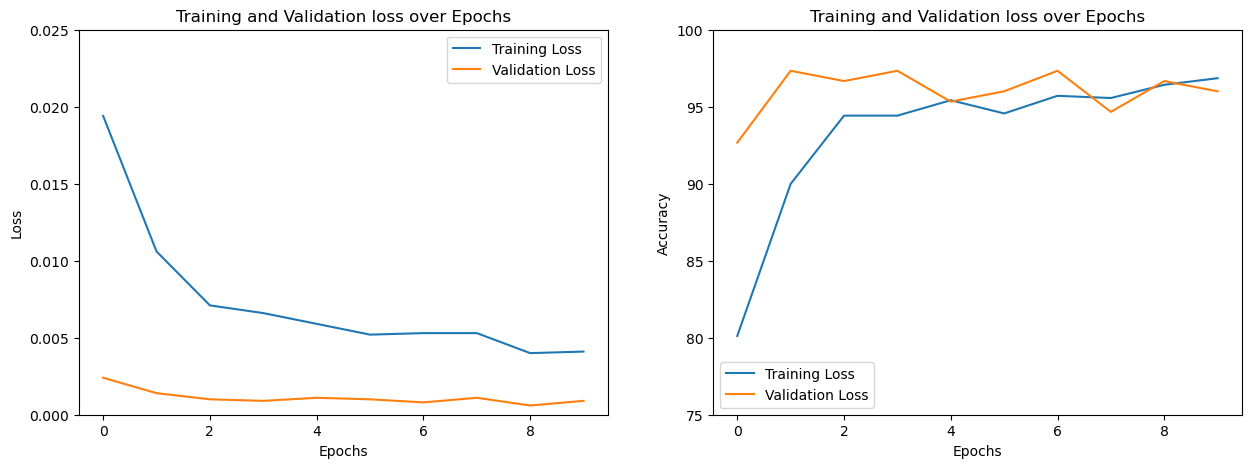

In [896]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

axs[0].plot(total_loss_train_plot, label = "Training Loss")
axs[0].plot(total_loss_validation_plot, label = "Validation Loss")
axs[0].set_title("Training and Validation loss over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_ylim([0,0.025])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label = "Training Loss")
axs[1].plot(total_acc_validation_plot, label = "Validation Loss")
axs[1].set_title("Training and Validation loss over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].set_ylim([75,100])
axs[1].legend()

plt.show()

In [898]:
torch.save(model.state_dict(), "fire.pth")

In [900]:
loaded_model = Net().to(device)
loaded_model.load_state_dict(torch.load("fire.pth"))
loaded_model.eval()

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=32768, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=2, bias=True)
)

In [902]:
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    
    model_prediction = loaded_model(image.unsqueeze(0))
    model_prediction = torch.argmax(model_prediction, axis = 1).item()
    
    return le.inverse_transform([model_prediction])

['fire_images']


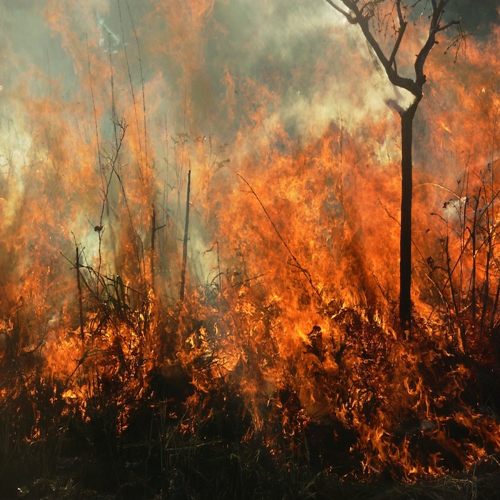

In [904]:
path1 = "/Users/jay/Jupyter Projects/Fire/inferno.jpeg"
print(predict_image(path1))
Image.open(path1).convert("RGB").resize([500, 500])

['non_fire_images']


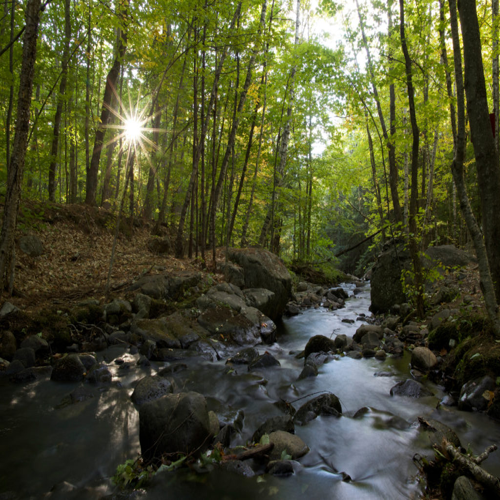

In [906]:
path2 = "/Users/jay/Jupyter Projects/Fire/Chill_Forest.jpeg"
print(predict_image(path2))
Image.open(path2).convert("RGB").resize([500, 500])

['fire_images']


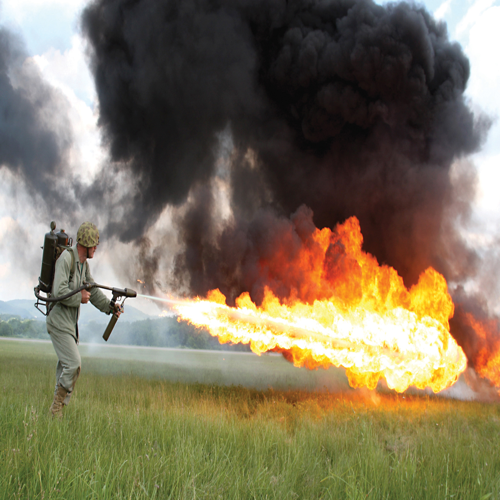

In [908]:
path3 = "/Users/jay/Jupyter Projects/Fire/flamethrower.jpeg"
print(predict_image(path3))
Image.open(path3).convert("RGB").resize([500, 500])

['non_fire_images']


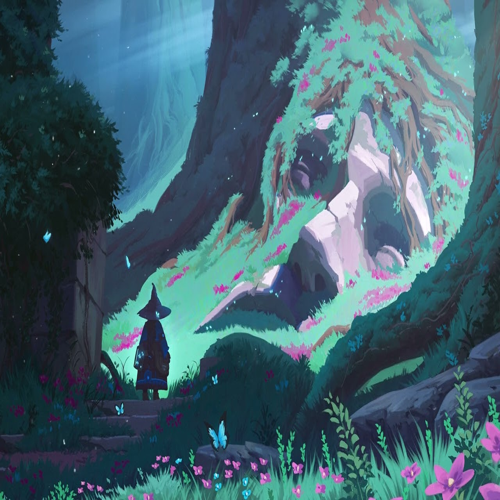

In [914]:
path4 = "/Users/jay/Jupyter Projects/Fire/Enchanted_Forest.jpeg"
print(predict_image(path4))
Image.open(path4).convert("RGB").resize([500, 500])

['fire_images']


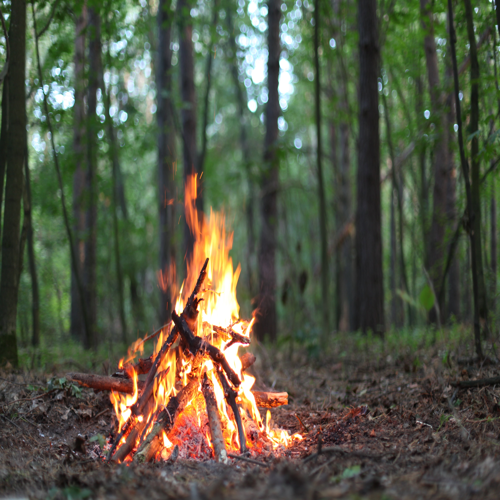

In [912]:
path5 = "/Users/jay/Jupyter Projects/Fire/camp_fire.jpeg"
print(predict_image(path5))
Image.open(path5).convert("RGB").resize([500, 500])